<a href="https://colab.research.google.com/github/mikulskibartosz/RNN_workshop/blob/main/RNN_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
raw_data = pd.read_csv('visitors.csv - Sheet1.csv')

In [3]:
raw_data.head()

,date,visitors
0,1/1/20,262
1,1/2/20,680
2,1/3/20,616
3,1/4/20,352
4,1/5/20,399


In [4]:
data = raw_data.copy()
data['date'] = pd.to_datetime(data.date)
data['day_of_week'] = data.date.dt.weekday

data['visitors'] = data['visitors'].str.replace(',', '')
data['visitors'] = data['visitors'].astype(int)

In [5]:
# angular distance between days of weeks
data['day_of_week_sin'] = np.sin(data['day_of_week'] * (2 * np.pi / 7))
data['day_of_week_cos'] = np.cos(data['day_of_week'] * (2 * np.pi / 7))

In [6]:
data['is_weekend'] = data['day_of_week'].isin([5, 6])

In [7]:
data.head()

,date,visitors,day_of_week,day_of_week_sin,day_of_week_cos,is_weekend
0,2020-01-01,262,2,0.974928,-0.222521,False
1,2020-01-02,680,3,0.433884,-0.900969,False
2,2020-01-03,616,4,-0.433884,-0.900969,False
3,2020-01-04,352,5,-0.974928,-0.222521,True
4,2020-01-05,399,6,-0.781831,0.623490,True


In [8]:
data['day_of_month'] = data.date.dt.day
data['day_of_month_sin'] = np.sin(data['day_of_month'] * (2 * np.pi / 7))
data['day_of_month_cos'] = np.cos(data['day_of_month'] * (2 * np.pi / 7))

In [9]:
data.head()

,date,visitors,day_of_week,day_of_week_sin,day_of_week_cos,is_weekend,day_of_month,day_of_month_sin,day_of_month_cos
0,2020-01-01,262,2,0.974928,-0.222521,False,1,0.781831,0.623490
1,2020-01-02,680,3,0.433884,-0.900969,False,2,0.974928,-0.222521
2,2020-01-03,616,4,-0.433884,-0.900969,False,3,0.433884,-0.900969
3,2020-01-04,352,5,-0.974928,-0.222521,True,4,-0.433884,-0.900969
4,2020-01-05,399,6,-0.781831,0.623490,True,5,-0.974928,-0.222521


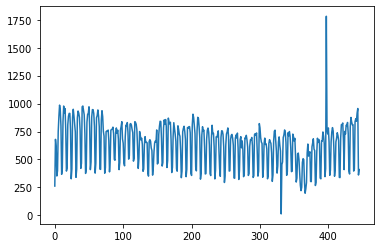

In [10]:
data['visitors'].plot()

In [11]:
data['visitors'].sort_values(ascending=False).head()

397    1781
7       986
13      978
41      978
50      971
Name: visitors, dtype: int64

In [12]:
data[394:400]

,date,visitors,day_of_week,day_of_week_sin,day_of_week_cos,is_weekend,day_of_month,day_of_month_sin,day_of_month_cos
394,2021-01-29,641,4,-0.433884,-0.900969,False,29,0.781831,0.623490
395,2021-01-30,346,5,-0.974928,-0.222521,True,30,0.974928,-0.222521
396,2021-01-31,418,6,-0.781831,0.623490,True,31,0.433884,-0.900969
397,2021-02-01,1781,0,0.000000,1.000000,False,1,0.781831,0.623490
398,2021-02-02,763,1,0.781831,0.623490,False,2,0.974928,-0.222521
399,2021-02-03,728,2,0.974928,-0.222521,False,3,0.433884,-0.900969


In [13]:
data.loc[data['visitors'] == 1781, 'visitors']  = (641+763+728) / 3

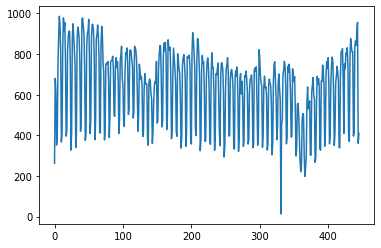

In [14]:
data['visitors'].plot()

In [15]:
data['visitors'].sort_values().head()

331     13.0
366    198.0
360    221.0
367    237.0
361    251.0
Name: visitors, dtype: float64

In [16]:
data[326:335]

,date,visitors,day_of_week,day_of_week_sin,day_of_week_cos,is_weekend,day_of_month,day_of_month_sin,day_of_month_cos
326,2020-11-22,441.0,6,-0.781831,0.623490,True,22,7.818315e-01,0.623490
327,2020-11-23,656.0,0,0.000000,1.000000,False,23,9.749279e-01,-0.222521
328,2020-11-24,702.0,1,0.781831,0.623490,False,24,4.338837e-01,-0.900969
329,2020-11-25,628.0,2,0.974928,-0.222521,False,25,-4.338837e-01,-0.900969
330,2020-11-26,575.0,3,0.433884,-0.900969,False,26,-9.749279e-01,-0.222521
331,2020-11-27,13.0,4,-0.433884,-0.900969,False,27,-7.818315e-01,0.623490
332,2020-11-28,454.0,5,-0.974928,-0.222521,True,28,-9.797174e-16,1.000000
333,2020-11-29,478.0,6,-0.781831,0.623490,True,29,7.818315e-01,0.623490
334,2020-11-30,696.0,0,0.000000,1.000000,False,30,9.749279e-01,-0.222521


In [17]:
data.loc[data['visitors'] == 13, 'visitors']  = (628 + 575 + 454 + 478) / 4

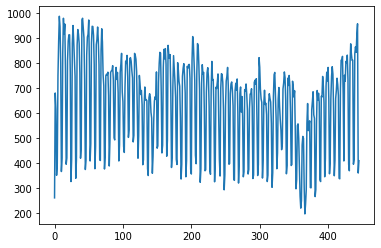

In [18]:
data['visitors'].plot()

In [19]:
data.head()

,date,visitors,day_of_week,day_of_week_sin,day_of_week_cos,is_weekend,day_of_month,day_of_month_sin,day_of_month_cos
0,2020-01-01,262.0,2,0.974928,-0.222521,False,1,0.781831,0.623490
1,2020-01-02,680.0,3,0.433884,-0.900969,False,2,0.974928,-0.222521
2,2020-01-03,616.0,4,-0.433884,-0.900969,False,3,0.433884,-0.900969
3,2020-01-04,352.0,5,-0.974928,-0.222521,True,4,-0.433884,-0.900969
4,2020-01-05,399.0,6,-0.781831,0.623490,True,5,-0.974928,-0.222521


In [20]:
features = data[['visitors', 'day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin', 'day_of_month_cos', 'is_weekend']]

In [21]:
n = len(features)
train_df = features[0:int(n*0.7)]
val_df = features[int(n*0.7):int(n*0.9)]
test_df = features[int(n*0.9):]

num_features = features.shape[1]

In [22]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result


  def plot(self, model=None, plot_col='visitors', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Days')

In [23]:
w1 = WindowGenerator(input_width=30, label_width=1, shift=1,
                     label_columns=['visitors'])

In [24]:
w1.make_dataset(train_df)

<MapDataset shapes: ((None, 30, 6), (None, 1, 1)), types: (tf.float32, tf.float32)>

In [25]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 31, 6)
Inputs shape: (3, 30, 6)
labels shape: (3, 1, 1)


In [26]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['visitors'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['visitors']

In [27]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 6)
Labels shape (batch, time, features): (32, 1, 1)


In [28]:
wide_window = WindowGenerator(
    input_width=30, label_width=30, shift=1,
    label_columns=['visitors'])

wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['visitors']

In [29]:
val_performance = {}
performance = {}

In [30]:
baseline = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [31]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [32]:
history = compile_and_fit(baseline, single_step_window)

val_performance['Linear'] = baseline.evaluate(single_step_window.val)
performance['Linear'] = baseline.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
10/10 [==============================] - 1s 57ms/step - loss: 478927.3125 - mean_absolute_error: 667.1756 - val_loss: 326454.8750 - val_mean_absolute_error: 547.1343
Epoch 2/20
10/10 [==============================] - 0s 13ms/step - loss: 458888.9176 - mean_absolute_error: 654.2614 - val_loss: 320280.3125 - val_mean_absolute_error: 541.7510
Epoch 3/20
10/10 [==============================] - 0s 14ms/step - loss: 451264.3210 - mean_absolute_error: 645.3176 - val_loss: 314205.2188 - val_mean_absolute_error: 536.3998
Epoch 4/20
10/10 [==============================] - 0s 14ms/step - loss: 435187.9545 - mean_absolute_error: 634.7578 - val_loss: 308183.8750 - val_mean_absolute_error: 531.0408
Epoch 5/20
10/10 [==============================] - 0s 13ms/step - loss: 430371.0881 - mean_absolute_error: 630.5288 - val_loss: 302216.1875 - val_mean_absolute_error: 525.6737
Epoch 6/20
10/10 [==============================] - 0s 13ms/step - loss: 421258.0369 - mean_absolute_error: 623.988

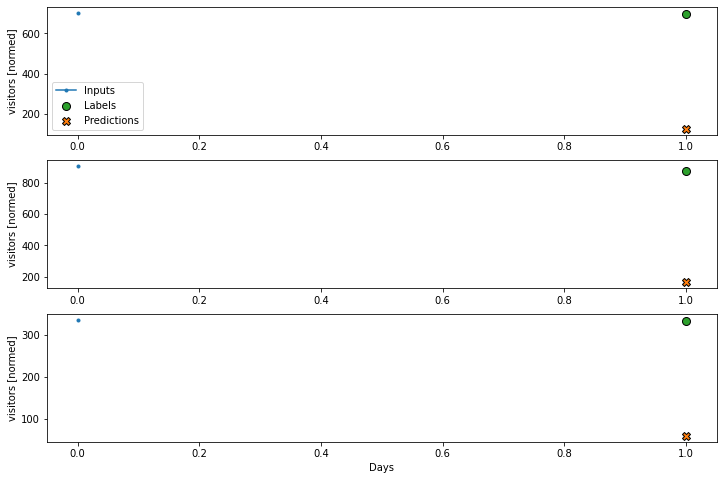

In [33]:
single_step_window.plot(baseline)

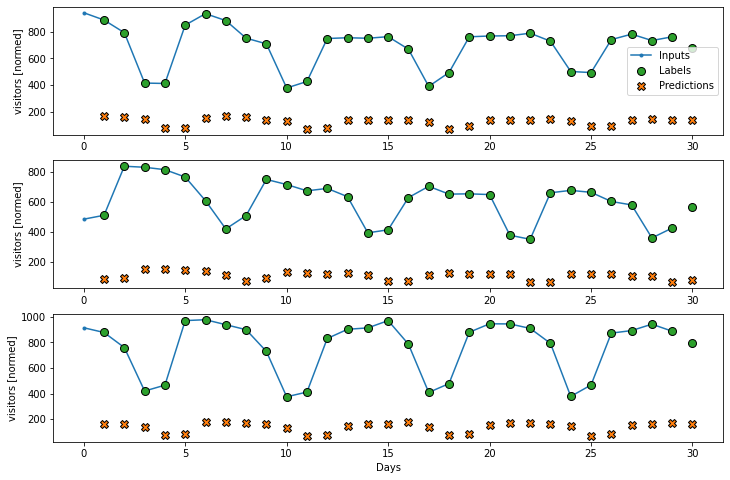

In [34]:
wide_window.plot(baseline)

In [35]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
10/10 [==============================] - 1s 35ms/step - loss: 546330.9233 - mean_absolute_error: 713.7964 - val_loss: 286783.1250 - val_mean_absolute_error: 511.5688
Epoch 2/20
10/10 [==============================] - 0s 16ms/step - loss: 384130.2983 - mean_absolute_error: 594.8905 - val_loss: 198808.9062 - val_mean_absolute_error: 421.4977
Epoch 3/20
10/10 [==============================] - 0s 16ms/step - loss: 251612.9702 - mean_absolute_error: 473.5107 - val_loss: 127589.3203 - val_mean_absolute_error: 330.0278
Epoch 4/20
10/10 [==============================] - 0s 15ms/step - loss: 159445.2798 - mean_absolute_error: 365.6175 - val_loss: 73033.0000 - val_mean_absolute_error: 239.4012
Epoch 5/20
10/10 [==============================] - 0s 14ms/step - loss: 84242.1562 - mean_absolute_error: 258.3857 - val_loss: 39538.7031 - val_mean_absolute_error: 170.2027
Epoch 6/20
10/10 [==============================] - 0s 15ms/step - loss: 50724.3700 - mean_absolute_error: 190.0235 - 

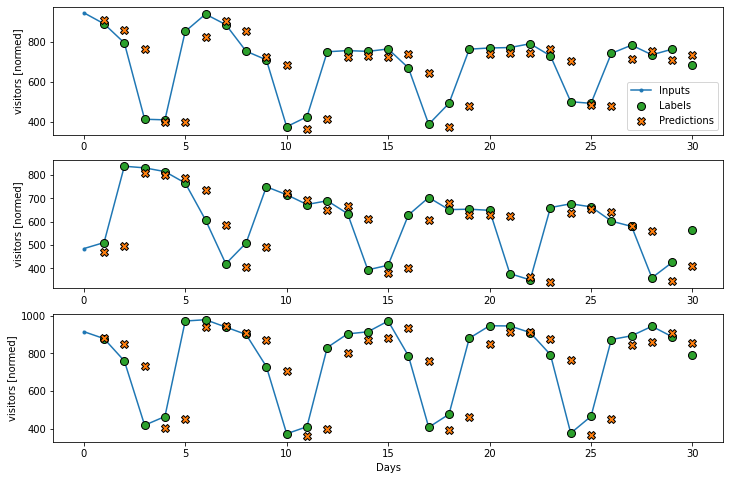

In [36]:
wide_window.plot(dense)

In [37]:
CONV_WIDTH = 14
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['visitors'])

conv_window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14]
Label column name(s): ['visitors']

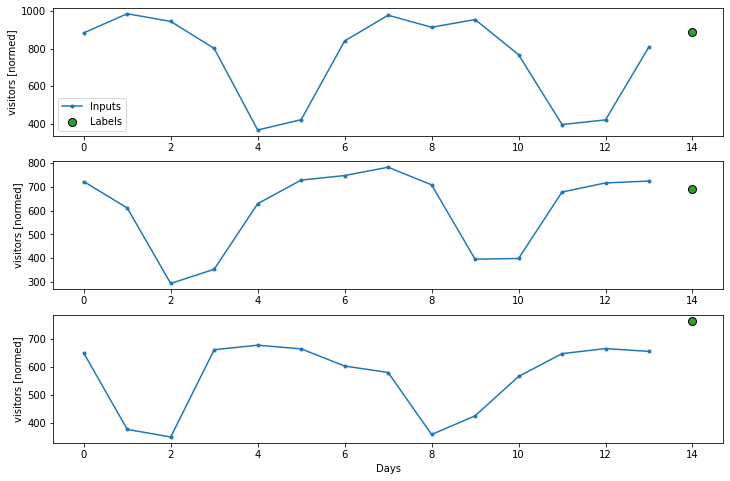

In [38]:
conv_window.plot()

In [39]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [40]:
history = compile_and_fit(multi_step_dense, conv_window)

val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/20
10/10 [==============================] - 1s 29ms/step - loss: 443430.0369 - mean_absolute_error: 627.5744 - val_loss: 63188.8594 - val_mean_absolute_error: 214.1784
Epoch 2/20
10/10 [==============================] - 0s 14ms/step - loss: 58232.8267 - mean_absolute_error: 206.0984 - val_loss: 36931.2188 - val_mean_absolute_error: 145.9491
Epoch 3/20
10/10 [==============================] - 0s 13ms/step - loss: 54406.8864 - mean_absolute_error: 168.1451 - val_loss: 25249.3633 - val_mean_absolute_error: 130.9583
Epoch 4/20
10/10 [==============================] - 0s 16ms/step - loss: 32534.4890 - mean_absolute_error: 144.2022 - val_loss: 21797.8398 - val_mean_absolute_error: 133.2474
Epoch 5/20
10/10 [==============================] - 0s 15ms/step - loss: 24127.1502 - mean_absolute_error: 137.8605 - val_loss: 16541.0195 - val_mean_absolute_error: 113.3997
Epoch 6/20
10/10 [==============================] - 0s 15ms/step - loss: 15793.5449 - mean_absolute_error: 100.0468 - val_lo

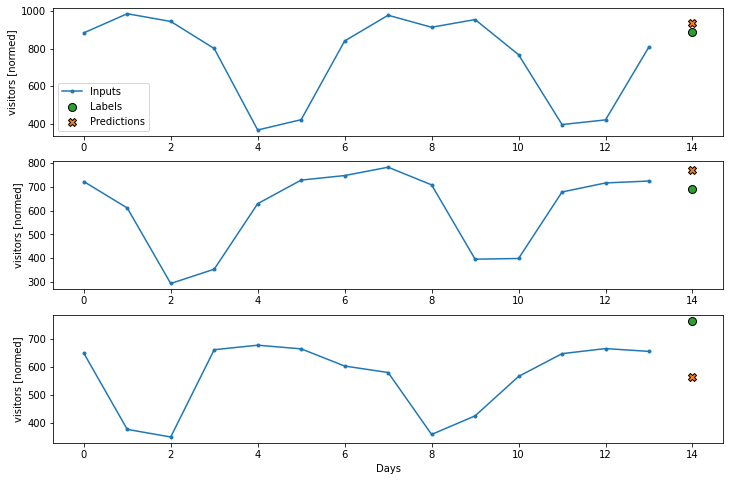

In [41]:
conv_window.plot(multi_step_dense)

In [42]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Epoch 1/20
10/10 [==============================] - 1s 35ms/step - loss: 487131.3438 - mean_absolute_error: 668.6442 - val_loss: 125410.7500 - val_mean_absolute_error: 316.2679
Epoch 2/20
10/10 [==============================] - 0s 14ms/step - loss: 127614.4070 - mean_absolute_error: 312.1413 - val_loss: 23779.2363 - val_mean_absolute_error: 139.3838
Epoch 3/20
10/10 [==============================] - 0s 14ms/step - loss: 29698.6483 - mean_absolute_error: 133.2961 - val_loss: 29736.3242 - val_mean_absolute_error: 133.2229
Epoch 4/20
10/10 [==============================] - 0s 16ms/step - loss: 29794.9636 - mean_absolute_error: 123.6527 - val_loss: 20792.2090 - val_mean_absolute_error: 129.6783
Epoch 5/20
10/10 [==============================] - 0s 14ms/step - loss: 21810.1282 - mean_absolute_error: 132.1001 - val_loss: 20380.1738 - val_mean_absolute_error: 128.0101
Epoch 6/20
10/10 [==============================] - 0s 14ms/step - loss: 19730.2646 - mean_absolute_error: 123.2353 - val_

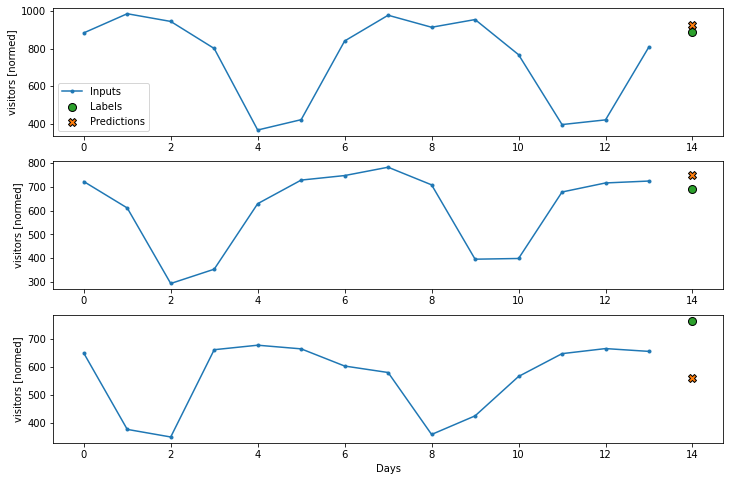

In [43]:
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)
conv_window.plot(conv_model)

In [44]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['visitors'])

wide_conv_window

Total window size: 38
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
Label indices: [14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
Label column name(s): ['visitors']

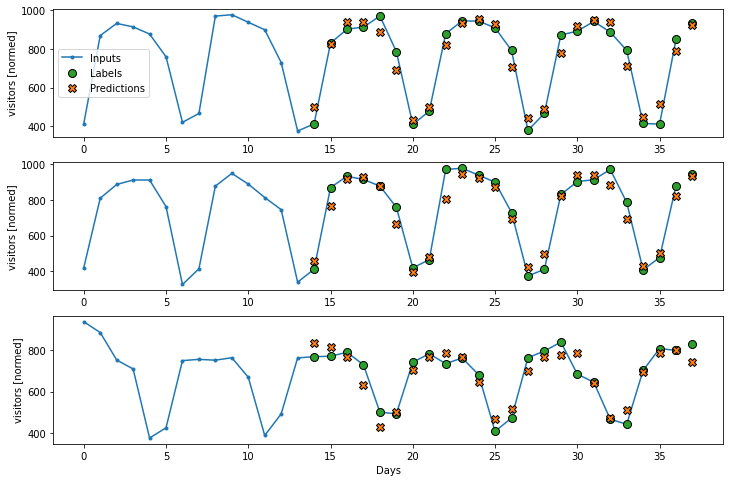

In [45]:
wide_conv_window.plot(conv_model)

In [57]:
lstm_window = WindowGenerator(
    input_width=60, label_width=60, shift=1,
    label_columns=['visitors'])

lstm_window

Total window size: 61
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60]
Label column name(s): ['visitors']

In [70]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(1024, return_sequences=True, activation="tanh"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(lstm_model, lstm_window, patience = 2)

val_performance['LSTM'] = lstm_model.evaluate(lstm_window.val)
performance['LSTM'] = lstm_model.evaluate(lstm_window.test, verbose=0)

Epoch 1/20
8/8 [==============================] - 31s 3s/step - loss: 455401.7083 - mean_absolute_error: 650.5756 - val_loss: 217643.0469 - val_mean_absolute_error: 434.4312
Epoch 2/20
8/8 [==============================] - 26s 3s/step - loss: 267753.3472 - mean_absolute_error: 473.3606 - val_loss: 212361.8906 - val_mean_absolute_error: 404.4880
Epoch 3/20
8/8 [==============================] - 26s 3s/step - loss: 77229.5755 - mean_absolute_error: 218.9625 - val_loss: 31075.7031 - val_mean_absolute_error: 145.9772
Epoch 4/20
8/8 [==============================] - 26s 3s/step - loss: 46100.0916 - mean_absolute_error: 192.2570 - val_loss: 42874.3789 - val_mean_absolute_error: 160.6708
Epoch 5/20
8/8 [==============================] - 26s 3s/step - loss: 35278.6758 - mean_absolute_error: 151.9416 - val_loss: 52850.7070 - val_mean_absolute_error: 176.9234
Epoch 6/20
8/8 [==============================] - 26s 3s/step - loss: 33430.2684 - mean_absolute_error: 154.7103 - val_loss: 36698.7578 

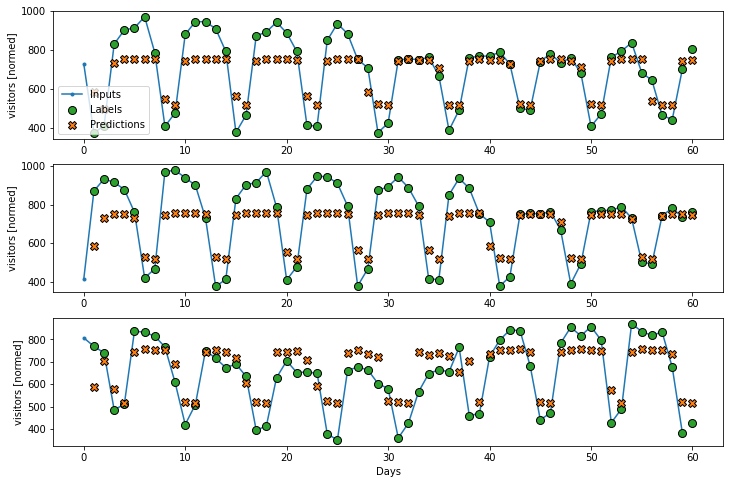

In [66]:
lstm_window.plot(lstm_model)

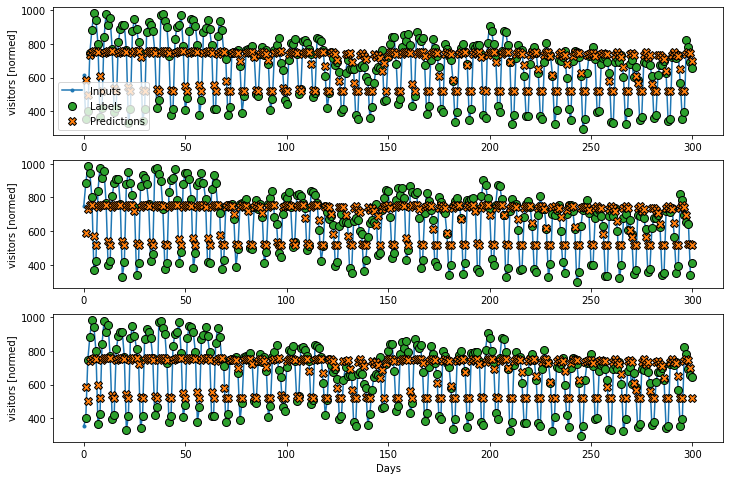

In [67]:
test_window = WindowGenerator(
    input_width=300, label_width=300, shift=1,
    label_columns=['visitors'])

test_window.plot(lstm_model)

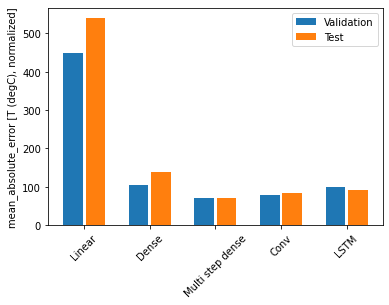

In [52]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()